# Drive và các thư viện cần thiết

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append("/content/drive/MyDrive/GaitGraph/src") # Để import các file python cùng folder

In [3]:
# !pip install pytorch-metric-learning
# from pytorch_metric_learning.losses import SupConLoss

In [4]:
import numpy as np
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import autocast, GradScaler

from graph import keypoints
from model_resgcn import ResGCN
from data import ProcessDataset
from augmentation import *
from losses import SupConLoss

%load_ext autoreload
%autoreload 2

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

## Transform data

In [20]:
data_transforms = {
    'train': TransformCompose([
        # InterpolateFrames(probability=0.9, target_frames=60),
        MirrorPoses(),
        PointNoise(),
        JointNoise(),
        FlipSequence()
        # DropOutJoints(prob=1.0, dropout_rate_range=0.2),
        # ShuffleSequence(enabled=True)
    ]),

    'valid': TransformCompose([
        # InterpolateFrames(probability=1.0)
        # ShuffleSequence(enabled=True)
    ])
}

data_transforms['train'] = TwoNoiseTransform(data_transforms['train'])
data_transforms['valid'] = TwoNoiseTransform(data_transforms['valid'])

## Load data

In [21]:
folder_path = '/content/drive/MyDrive/GaitGraph/data/CasiaB_Pose_Data'

path_train = os.path.join(folder_path, "casia-b_pose_train_valid.csv")
path_valid = os.path.join(folder_path, "casia-b_pose_test.csv")

In [22]:
dataset = {
    'train': ProcessDataset(csv_path=path_train, transform=data_transforms['train']),
    'valid': ProcessDataset(csv_path=path_valid, transform=data_transforms['valid'])
    # 'valid': ProcessDataset(csv_path=path_valid)
}

In [23]:
train_data_size = len(dataset['train'])
valid_data_size = len(dataset['valid'])
print("Train Dataset size: ", train_data_size)
print("Valid Dataset size: ", valid_data_size)

# sample = dataset['train'][0]
# sample

Train Dataset size:  8004
Valid Dataset size:  5406


## Lấy data, label

In [24]:
# split: 'train' hoặc 'valid'
def load_data(split='train'):
    X = []
    Y = []

    data_split = dataset[split]
    for i in range(len(data_split)):
        data = data_split[i]
        X.append(data['node_features'])
        Y.append(data['subject_id'])

    return np.array(X), np.array(Y)

In [25]:
X_train, Y_train = load_data(split='train')
X_valid, Y_valid = load_data(split='valid')

In [26]:
print(X_train.shape)
print(Y_train.shape)

print(X_valid.shape)
print(Y_valid.shape)

(8004, 2, 60, 17, 3)
(8004,)
(5406, 2, 60, 17, 3)
(5406,)


In [27]:
batch_size_train = 128
batch_size_valid = 256

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
Y_valid_tensor = torch.tensor(Y_valid, dtype=torch.long)
valid_dataset = TensorDataset(X_valid_tensor, Y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size_valid, shuffle=False)

In [28]:
# In shape của dữ liệu trong train_loader và valid_loader
for idx, (x_batch, y_batch) in enumerate(train_loader):
    print(f"Train batch {idx + 1}: x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")
    break  # In một batch đầu tiên và dừng lại, tránh lặp vô tận

for idx, (x_batch, y_batch) in enumerate(valid_loader):
    print(f"Valid batch {idx + 1}: x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")
    break  # In một batch đầu tiên và dừng lại, tránh lặp vô tận


Train batch 1: x_batch shape: torch.Size([128, 2, 60, 17, 3]), y_batch shape: torch.Size([128])
Valid batch 1: x_batch shape: torch.Size([256, 2, 60, 17, 3]), y_batch shape: torch.Size([256])


# Khởi tạo model

In [36]:
model = ResGCN()
model.to(device)

ResGCN(
  (input_branches): ModuleList(
    (0): ResGCN_Input_Branch(
      (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers): ModuleList(
        (0): ResGCN_Module(
          (scn): Spatial_Basic_Block(
            (conv): SpatialGraphConv(
              (gcn): Conv2d(3, 192, kernel_size=(1, 1), stride=(1, 1))
            )
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
          )
          (tcn): Temporal_Basic_Block(
            (conv): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
          )
        )
        (1): ResGCN_Module(
          (scn): Spatial_Bottleneck_Block(
            (conv_down): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
            (bn_down): BatchNorm2d(8, eps=1e

In [16]:
# from torchsummary import summary
# summary(model, input_size=(60, 17, 3))

**Khai báo các thông số**

In [37]:
loss_fn = SupConLoss(temperature=0.01)
steps_per_epoch = len(train_loader)

lr1 = 0.01
# Lần 1
optimizer1 = optim.Adam(model.parameters(), lr=lr1, weight_decay=1e-5)
scheduler1 = OneCycleLR(
    optimizer1,
    max_lr=lr1,
    epochs=300,
    steps_per_epoch=steps_per_epoch
)

# lr2 = 1e-5
lr2 = 0.008
# Lần 2
optimizer2 = optim.Adam(model.parameters(), lr=lr2, weight_decay=1e-5)
scheduler2 = OneCycleLR(
    optimizer2,
    max_lr=lr2,
    epochs=100,
    steps_per_epoch=steps_per_epoch
)

**Đưa checkpoint vào model**

In [38]:
best_checkpoint = "/content/drive/MyDrive/GaitGraph/save/best_checkpoint.pth"

# Nếu checkpoint đã tồn tại thì load
if os.path.exists(best_checkpoint):
    checkpoint = torch.load(best_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model = model.state_dict()
    best_optimizer = optimizer1.load_state_dict(checkpoint['optimizer_state_dict'])
    best_scheduler = scheduler1.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    loss_history = checkpoint['loss_history']
    print(f"Loaded checkpoint from epoch {start_epoch} with best loss {best_loss:.4f}")
else:
    start_epoch = 1
    best_loss = float('inf')
    best_model = None
    best_optimizer = None
    best_scheduler = None
    loss_history = []
    print("No checkpoint found, starting training from scratch.")

Loaded checkpoint from epoch 300 with best loss 0.8236


In [39]:
best_checkpoint2 = "/content/drive/MyDrive/GaitGraph/save/best_checkpoint2.pth"
loss_history2 = []

# Train + Valid

In [32]:
def inspect_model_input_output(train_loader, valid_loader, model, device):
    model.eval()

    # Kiểm tra với train_loader
    print("=== Inspecting train_loader ===")
    X_batch, y_batch = next(iter(train_loader))
    X_batch = X_batch.to(device)  # [B, 2, T, V, C]
    y_batch = y_batch.to(device)

    print("Train X_batch shape:", X_batch.shape)  # [B, 2, T, V, C]
    print("Train y_batch shape:", y_batch.shape)

    view1 = X_batch[:, 0, :, :, :]  # [B, T, V, C]
    view2 = X_batch[:, 1, :, :, :]  # [B, T, V, C]

    print("Train view1 shape:", view1.shape)
    print("Train view2 shape:", view2.shape)

    out1 = model(view1)  # [B, feature_dim]
    out2 = model(view2)

    print("Train out1 shape:", out1.shape)
    print("Train out2 shape:", out2.shape)

    # Kiểm tra với valid_loader
    print("\n=== Inspecting valid_loader ===")
    X_val, y_val = next(iter(valid_loader))  # [B, 2, T, V, C]
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    print("Valid X_val shape:", X_val.shape)  # [B, 2, T, V, C]
    print("Valid y_val shape:", y_val.shape)

    # Kiểm tra và xử lý nếu valid_loader cũng trả về 2 views
    view1_val = X_val[:, 0, :, :, :]  # [B, T, V, C]
    view2_val = X_val[:, 1, :, :, :]  # [B, T, V, C]

    print("Valid view1 shape:", view1_val.shape)
    print("Valid view2 shape:", view2_val.shape)

    out1_val = model(view1_val)
    out2_val = model(view2_val)

    print("Valid out1 shape:", out1_val.shape)
    print("Valid out2 shape:", out2_val.shape)


inspect_model_input_output(train_loader, valid_loader, model, device)

=== Inspecting train_loader ===
Train X_batch shape: torch.Size([128, 2, 60, 17, 3])
Train y_batch shape: torch.Size([128])
Train view1 shape: torch.Size([128, 60, 17, 3])
Train view2 shape: torch.Size([128, 60, 17, 3])
Train out1 shape: torch.Size([128, 128])
Train out2 shape: torch.Size([128, 128])

=== Inspecting valid_loader ===
Valid X_val shape: torch.Size([256, 2, 60, 17, 3])
Valid y_val shape: torch.Size([256])
Valid view1 shape: torch.Size([256, 60, 17, 3])
Valid view2 shape: torch.Size([256, 60, 17, 3])
Valid out1 shape: torch.Size([256, 128])
Valid out2 shape: torch.Size([256, 128])


In [40]:
def train_and_validate(
    model, loss_fn, optimizer, scheduler, num_epochs, start_epoch,
    best_loss, best_model, best_optimizer, best_scheduler, loss_history, use_amp=True
    ):
    scaler = GradScaler(enabled=use_amp)
    best_epoch = start_epoch

    for epoch in range(start_epoch, start_epoch + num_epochs):

        start_time = time.time()

        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            # X_batch: [B, 2, T, V, C]
            X_batch = X_batch.to(device, non_blocking=True)  # [B, 2, T, V, C]
            y_batch = y_batch.to(device, non_blocking=True)
            bsz = y_batch.size(0)

            optimizer.zero_grad()

            # Tách 2 views
            view1 = X_batch[:, 0]
            view2 = X_batch[:, 1]
            points = torch.cat([view1, view2], dim=0)

            with autocast(enabled=use_amp):
                features = model(points)  # [2B, feature_dim]
                f1, f2 = torch.split(features, [bsz, bsz], dim=0)
                features_pair = torch.stack([f1, f2], dim=1)  # [B, 2, feature_dim]
                loss = loss_fn(features_pair, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scheduler.step()
            scaler.update()
            # optimizer.zero_grad() # Xóa gradients mỗi batch

            running_loss += loss.item() # Cộng dồn loss

        avg_loss = running_loss / len(train_loader)
        print(f"[Train] Epoch {epoch}/{start_epoch + num_epochs - 1}, Loss: {avg_loss:.4f}")

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr}")

        # Validation phase
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in valid_loader:
                X_val = X_val.to(device, non_blocking=True)
                y_val = y_val.to(device, non_blocking=True)
                bsz = y_val.size(0)

                view1 = X_val[:, 0]
                view2 = X_val[:, 1]
                points_val = torch.cat([view1, view2], dim=0)

                with autocast(enabled=use_amp):
                    features_val = model(points_val)  # [2B, feature_dim]
                    f1_val, f2_val = torch.split(features_val, [bsz, bsz], dim=0)
                    features_val_pair = torch.stack([f1_val, f2_val], dim=1)  # [B, 2, feature_dim]
                    loss_val = loss_fn(features_val_pair, y_val)

                valid_loss += loss_val.item()

        avg_valid_loss = valid_loss / len(valid_loader)
        loss_history.append(avg_valid_loss)
        print(f"[Valid] Epoch {epoch}, Loss: {avg_valid_loss:.4f}")

        # Save best checkpoint based on valid loss
        if avg_valid_loss < best_loss:
            best_epoch = epoch
            best_model = model.state_dict()
            best_optimizer = optimizer.state_dict()
            best_scheduler = scheduler.state_dict()
            best_loss = avg_valid_loss
            print(f"Best loss mới = {best_loss} nhưng chưa lưu")

        if epoch % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model,
                'optimizer_state_dict': best_optimizer,
                'scheduler_state_dict': best_scheduler,
                'best_loss': best_loss,
                'loss_history': loss_history
            }, best_checkpoint2)
            print(f"Model lưu ở epoch {epoch} nhưng lưu trọng số tốt nhất ở epoch {best_epoch}")

        epoch_time = time.time() - start_time
        print(f"Time: {epoch_time:.2f} giây\n")

    return best_loss


## 300 epochs đầu

In [34]:
best_loss1 = train_and_validate(
    model=model, loss_fn=loss_fn, optimizer=optimizer1, scheduler=scheduler1, num_epochs=300, start_epoch=start_epoch,
    best_loss=best_loss, best_model=best_model, best_optimizer=best_optimizer, best_scheduler=best_scheduler, loss_history = loss_history
    )

<ipython-input-33-11b385c0bcb5>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)
<ipython-input-33-11b385c0bcb5>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[Train] Epoch 1/300, Loss: 0.7826
Learning rate: 0.0004029250618804558


<ipython-input-33-11b385c0bcb5>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


[Valid] Epoch 1, Loss: 0.8870
Best loss mới = 0.8870106014338407 nhưng chưa lưu
Time: 15.61 giây

[Train] Epoch 2/300, Loss: 0.7230
Learning rate: 0.00041169668252724265
[Valid] Epoch 2, Loss: 0.9134
Time: 14.13 giây

[Train] Epoch 3/300, Loss: 0.6760
Learning rate: 0.00042630417130152913
[Valid] Epoch 3, Loss: 0.9451
Time: 13.84 giây

[Train] Epoch 4/300, Loss: 0.6547
Learning rate: 0.0004467297249497442
[Valid] Epoch 4, Loss: 0.9286
Time: 13.73 giây

[Train] Epoch 5/300, Loss: 0.6255
Learning rate: 0.0004729484493017338
[Valid] Epoch 5, Loss: 0.9945
Time: 13.72 giây

[Train] Epoch 6/300, Loss: 0.6021
Learning rate: 0.0005049283896111818
[Valid] Epoch 6, Loss: 0.9288
Time: 13.80 giây

[Train] Epoch 7/300, Loss: 0.5934
Learning rate: 0.0005426305695012817
[Valid] Epoch 7, Loss: 0.9791
Time: 13.90 giây

[Train] Epoch 8/300, Loss: 0.5737
Learning rate: 0.0005860090384681976
[Valid] Epoch 8, Loss: 0.9291
Time: 13.91 giây

[Train] Epoch 9/300, Loss: 0.5711
Learning rate: 0.0006350109278844

In [ ]:
# # Nếu chia nhiều lần train khác nhau (tổng phải đúng 300)
# best_loss1 = train_and_validate(
#     model=model, loss_fn=loss_fn, optimizer=optimizer1, scheduler=scheduler1, num_epochs=100,
#     start_epoch=start_epoch, best_loss=best_loss, best_model=best_model, best_optimizer=best_optimizer, best_scheduler=best_scheduler
#     )
# best_loss1 = train_and_validate(
#     model=model, loss_fn=loss_fn, optimizer=optimizer1, scheduler=scheduler1, num_epochs=200,
#     start_epoch=start_epoch+1, best_loss=best_loss, best_model=best_model, best_optimizer=best_optimizer, best_scheduler=best_scheduler
#     )


## 100 epochs sau

**Lưu ý không bấm chạy nhiều lần sẽ bị lỗi scheduler**

In [41]:
best_loss2 = train_and_validate(
    model=model, loss_fn=loss_fn, optimizer=optimizer2, scheduler=scheduler2, num_epochs=100,
    start_epoch=1, best_loss=float('inf'), best_model=best_model, best_optimizer=None, best_scheduler=None, loss_history = loss_history2
    )

<ipython-input-40-317e2a2a59d4>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)
<ipython-input-40-317e2a2a59d4>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


[Train] Epoch 1/100, Loss: 0.1843
Learning rate: 0.0003410581793158486


<ipython-input-40-317e2a2a59d4>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


[Valid] Epoch 1, Loss: 0.9263
Best loss mới = 0.9263389896262776 nhưng chưa lưu
Time: 14.03 giây

[Train] Epoch 2/100, Loss: 0.1833
Learning rate: 0.0004040017553279245
[Valid] Epoch 2, Loss: 0.9264
Time: 13.96 giây

[Train] Epoch 3/100, Loss: 0.1883
Learning rate: 0.0005081403753745403
[Valid] Epoch 3, Loss: 0.9256
Best loss mới = 0.9255967925895344 nhưng chưa lưu
Time: 13.69 giây

[Train] Epoch 4/100, Loss: 0.1834
Learning rate: 0.000652331867718901
[Valid] Epoch 4, Loss: 0.9261
Time: 13.53 giây

[Train] Epoch 5/100, Loss: 0.1873
Learning rate: 0.0008349947686622514
[Valid] Epoch 5, Loss: 0.9284
Time: 13.51 giây

[Train] Epoch 6/100, Loss: 0.1887
Learning rate: 0.0010541256677241663
[Valid] Epoch 6, Loss: 0.9267
Time: 13.51 giây

[Train] Epoch 7/100, Loss: 0.1912
Learning rate: 0.001307321180651474
[Valid] Epoch 7, Loss: 0.9371
Time: 13.60 giây

[Train] Epoch 8/100, Loss: 0.1954
Learning rate: 0.0015918043092602212
[Valid] Epoch 8, Loss: 0.9328
Time: 13.65 giây

[Train] Epoch 9/100, 

## Vẽ loss

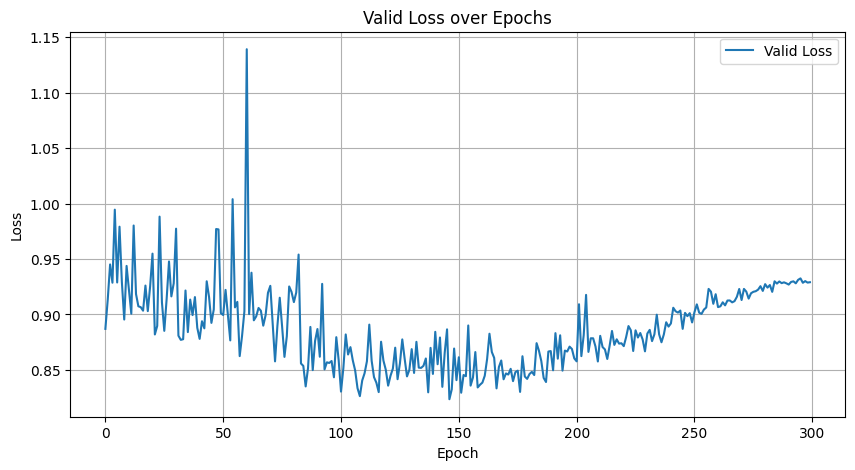

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Valid Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

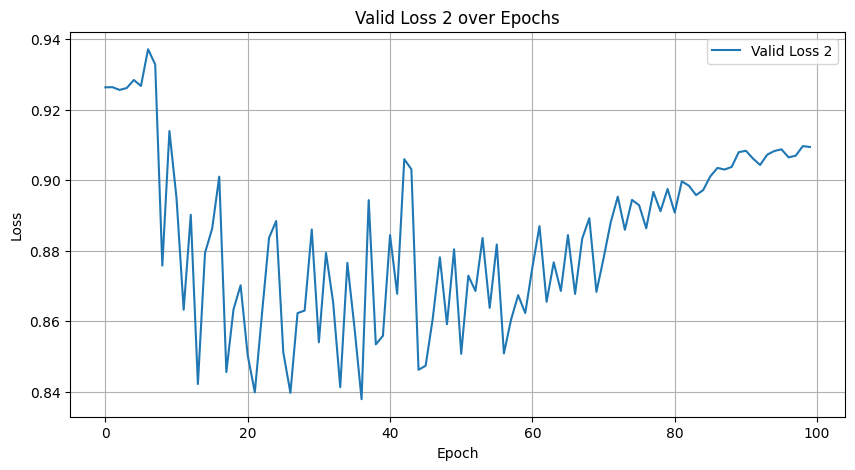

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history2, label='Valid Loss 2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Valid Loss 2 over Epochs')
plt.legend()
plt.grid(True)
plt.show()